In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import os

# Set benchmark for CUDA
torch.backends.cudnn.benchmark = True

# Function to get datasets
def get_datasets():
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    fmnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    fmnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    return {
        'MNIST': (mnist_train, mnist_test),
        'FMNIST': (fmnist_train, fmnist_test),
        'CIFAR-10': (cifar10_train, cifar10_test)
    }

# LeNet5 Model
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*13*13, 120)  # Adjusted for (64, 64) input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*13*13)  # Adjusted for (64, 64) input size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
# AlexNet Model
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Calculating the output size after the 'features' part
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # Output size of 6x6 regardless of input size
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the output of 'features' to feed into 'classifier'
        x = self.classifier(x)
        return x

# VGG Model
class VGG(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64 -> 32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4 -> 2x2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# GoogLeNet
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.a3 = Inception(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inception(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inception(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inception(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)
        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.maxpool(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Inception Module for GoogLeNet
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


# BasicBlock for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
# ResNet18 Model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet18, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, 1)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return x * out

# SENet Model
class SENet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(SENet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64)
        
        self.layer1 = self._make_layer(64, 128, 2, stride=1)
        self.layer2 = self._make_layer(128, 256, 2, stride=2)
        self.layer3 = self._make_layer(256, 512, 2, stride=2)
        self.layer4 = self._make_layer(512, 1024, 2, stride=2)
        
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, in_planes, planes, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(self._make_block(in_planes, planes, stride))
            in_planes = planes
            stride = 1  # Only the first block of each layer uses a stride
        return nn.Sequential(*layers)

    def _make_block(self, in_planes, planes, stride):
        return nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True),
            SEBlock(planes)
        )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.se1(out)
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = F.avg_pool2d(out, out.size()[2:])  # Dynamically Adjusting pooling kernel size
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Function to train the model
def train(model, train_loader, criterion, optimizer, device, num_epochs=5, scheduler=None):
    loss_list = []
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_list.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        if scheduler is not None:
            scheduler.step()
    return loss_list

# Function to test the model
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_loss = running_loss / len(test_loader)
    print(f'Accuracy of the network on the test images: {accuracy:.2f} %')
    print(f'Test loss: {test_loss}')
    return accuracy

# Main loop
if __name__ == '__main__':
    batch_size = 128
    num_epochs = 5
    learning_rate = 0.001

    # Load datasets
    datasets = get_datasets()

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Results dictionary
    results = {}

    # Train and evaluate models on each dataset
    for dataset_name, (trainset, testset) in datasets.items():
        print(f"\nDataset: {dataset_name}")
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
        testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

        models = {
            'LeNet5': LeNet5(num_classes=10),
            'AlexNet': AlexNet(num_classes=10),
            'GoogLeNet': GoogLeNet(num_classes=10),
            'VGG': VGG(num_classes=10),
            'ResNet18': ResNet18(num_classes=10),
            'SENet': SENet(num_classes=10)
        }

        dataset_results = {}

        for model_name, model in models.items():
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

            print(f'Training {model_name} on {dataset_name}...')
            loss_list = train(model, trainloader, criterion, optimizer, device, num_epochs=num_epochs, scheduler=scheduler)
            accuracy = test(model, testloader, criterion, device)

            dataset_results[model_name] = {
                'loss_list': loss_list,
                'accuracy': accuracy
            }

        results[dataset_name] = dataset_results

    # Plotting results
    for dataset_name, dataset_results in results.items():
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f"Model Performance on {dataset_name}")

        for model_name, metrics in dataset_results.items():
            epochs = list(range(1, num_epochs + 1))
            train_losses = metrics['loss_list']
            accuracy = metrics['accuracy']

            # Plotting Loss Curve
            axes[0].plot(epochs, train_losses, label=f"{model_name} Loss")
            axes[0].set_title('Loss Curve')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Loss')

            # Plotting Accuracy Curve
            axes[1].plot(epochs, [accuracy] * num_epochs, '--', label=f"{model_name} Accuracy")
            axes[1].set_title('Accuracy Curve')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Accuracy')

        for ax in axes:
            ax.legend()

    plt.show()


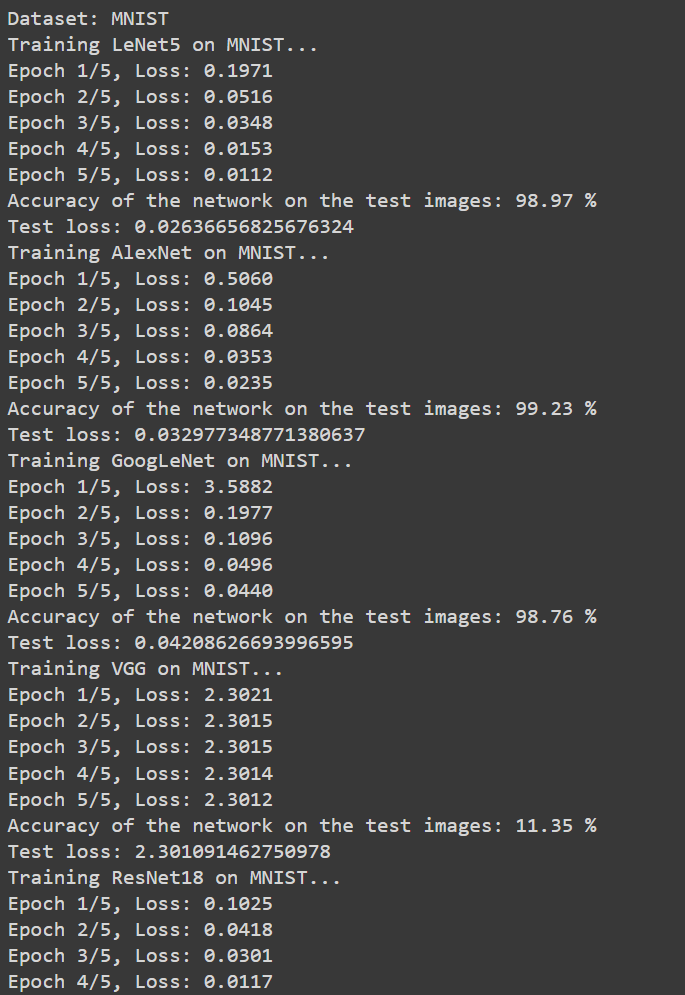
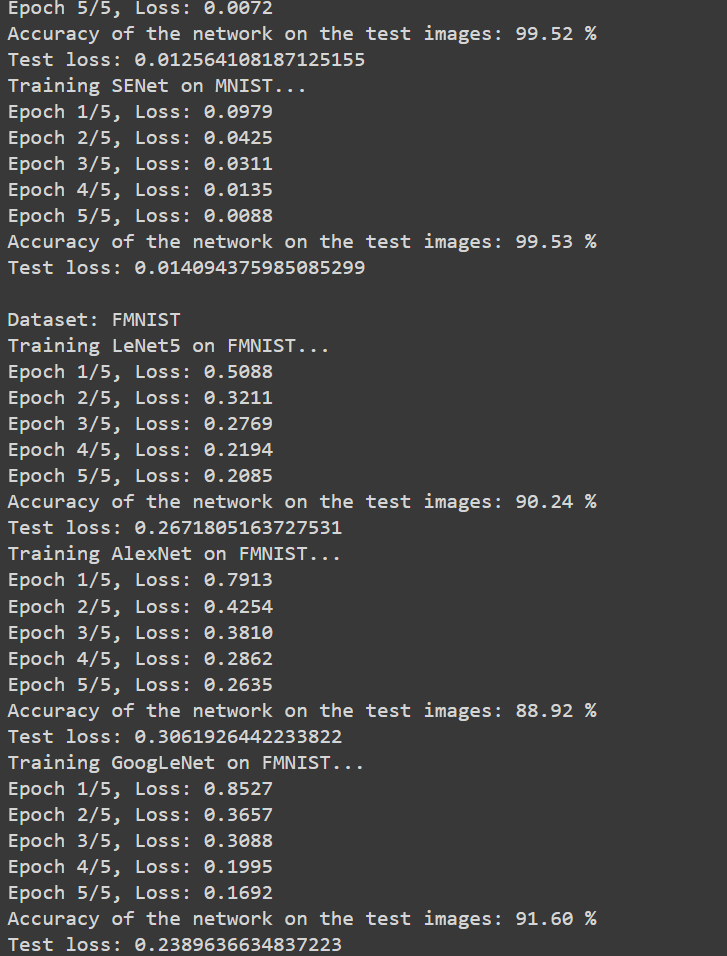
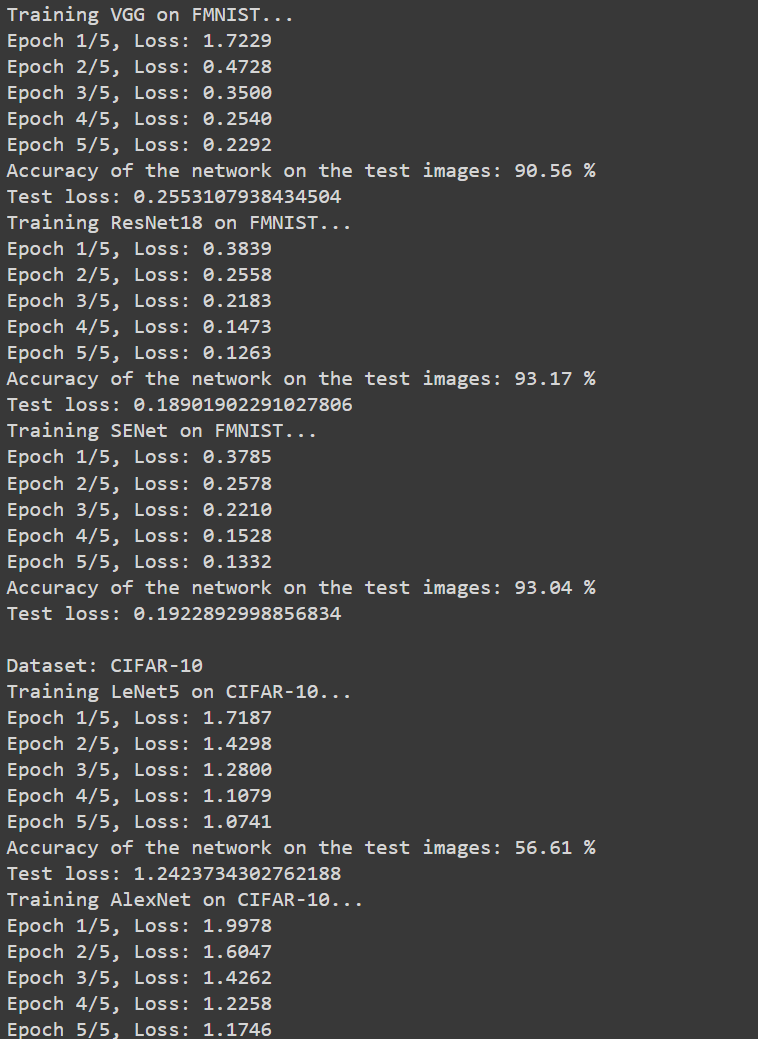
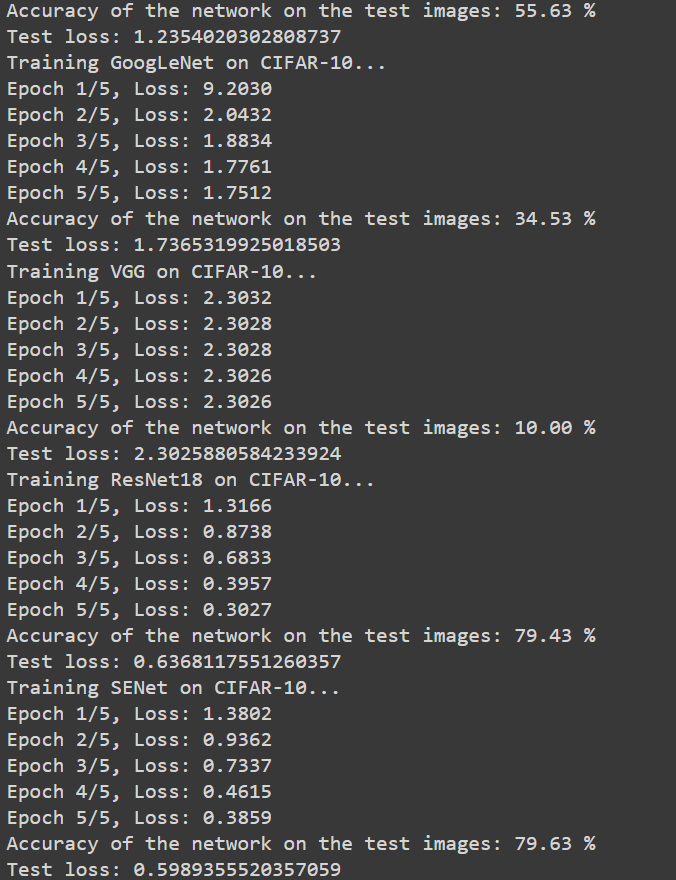

![CIFAR-10(IMG).png](attachment:CIFAR-10(IMG).png) ![FMNIST(IMG).png](attachment:FMNIST(IMG).png) ![MNIST(IMG).png](attachment:MNIST(IMG).png)
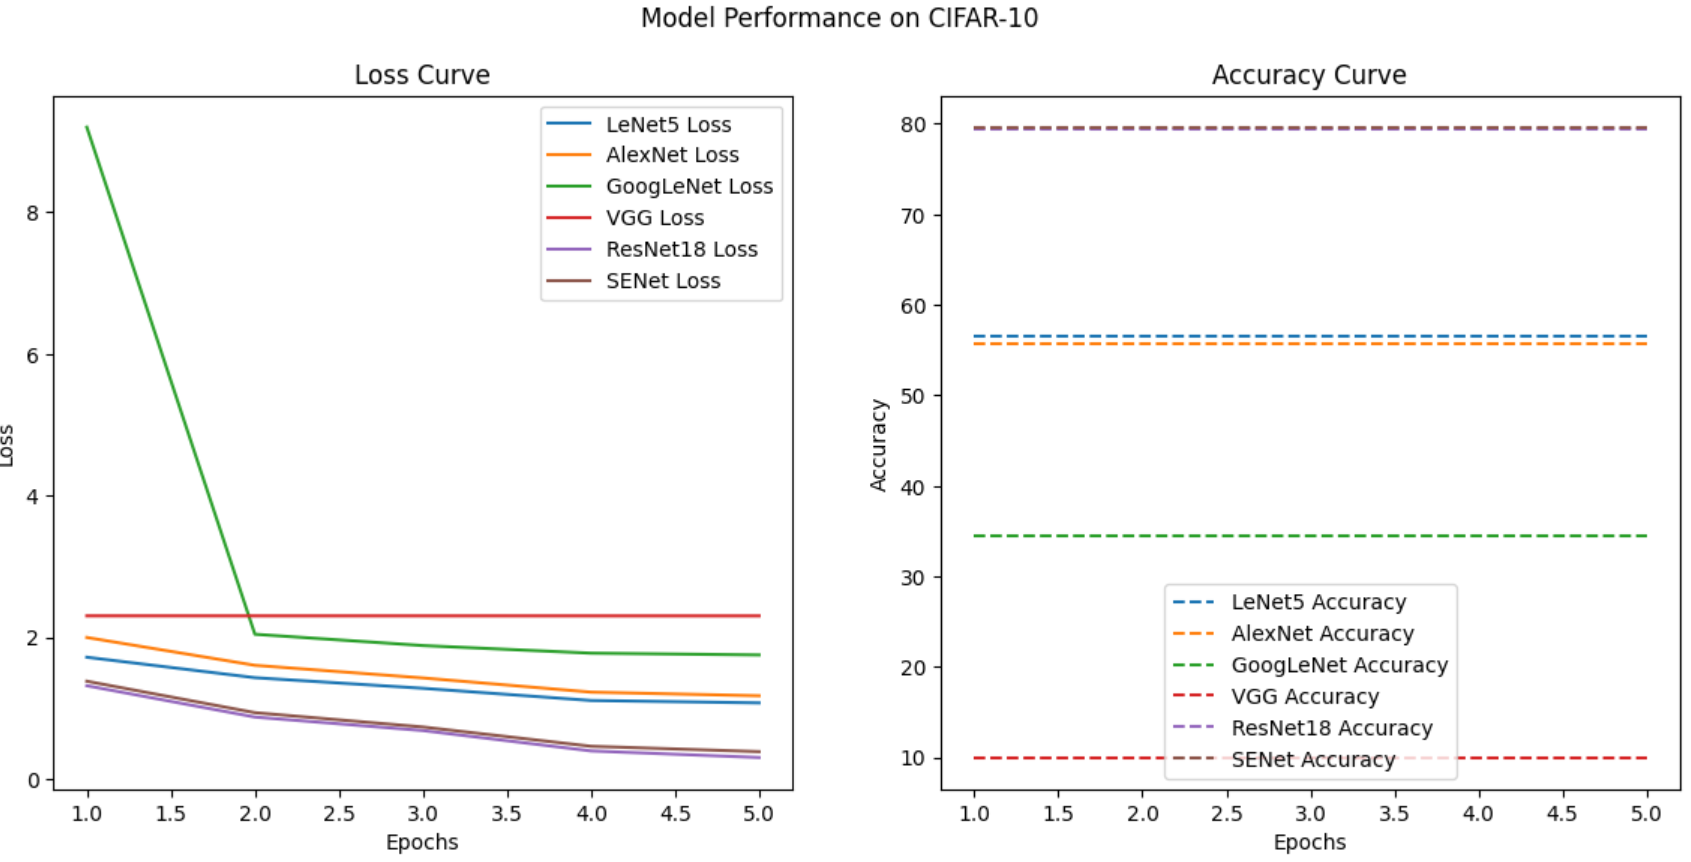
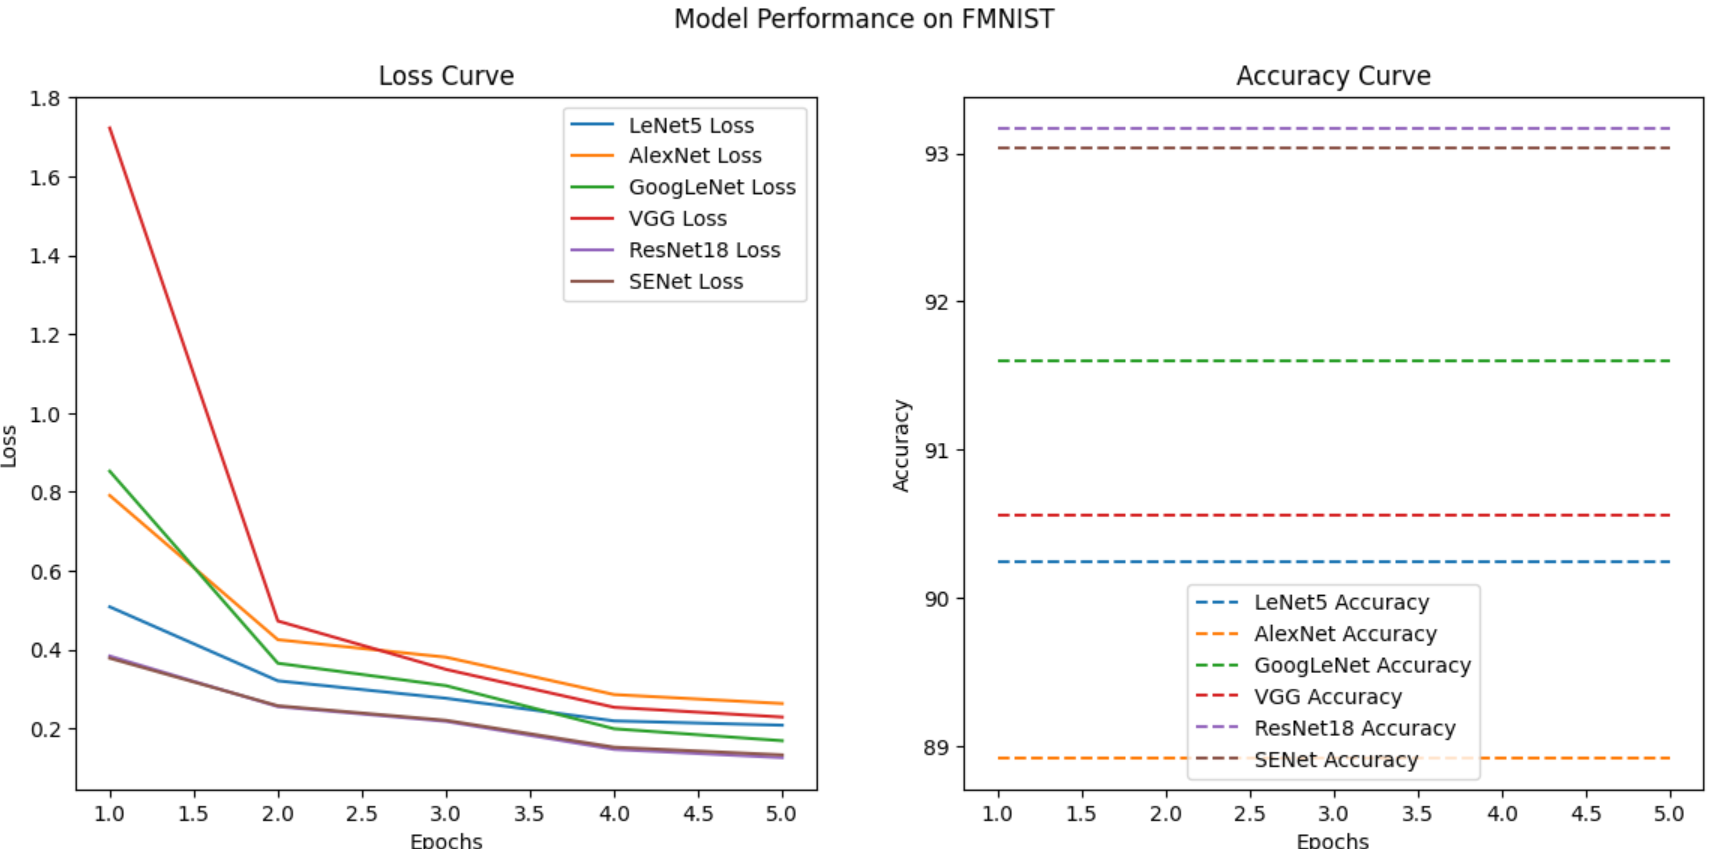
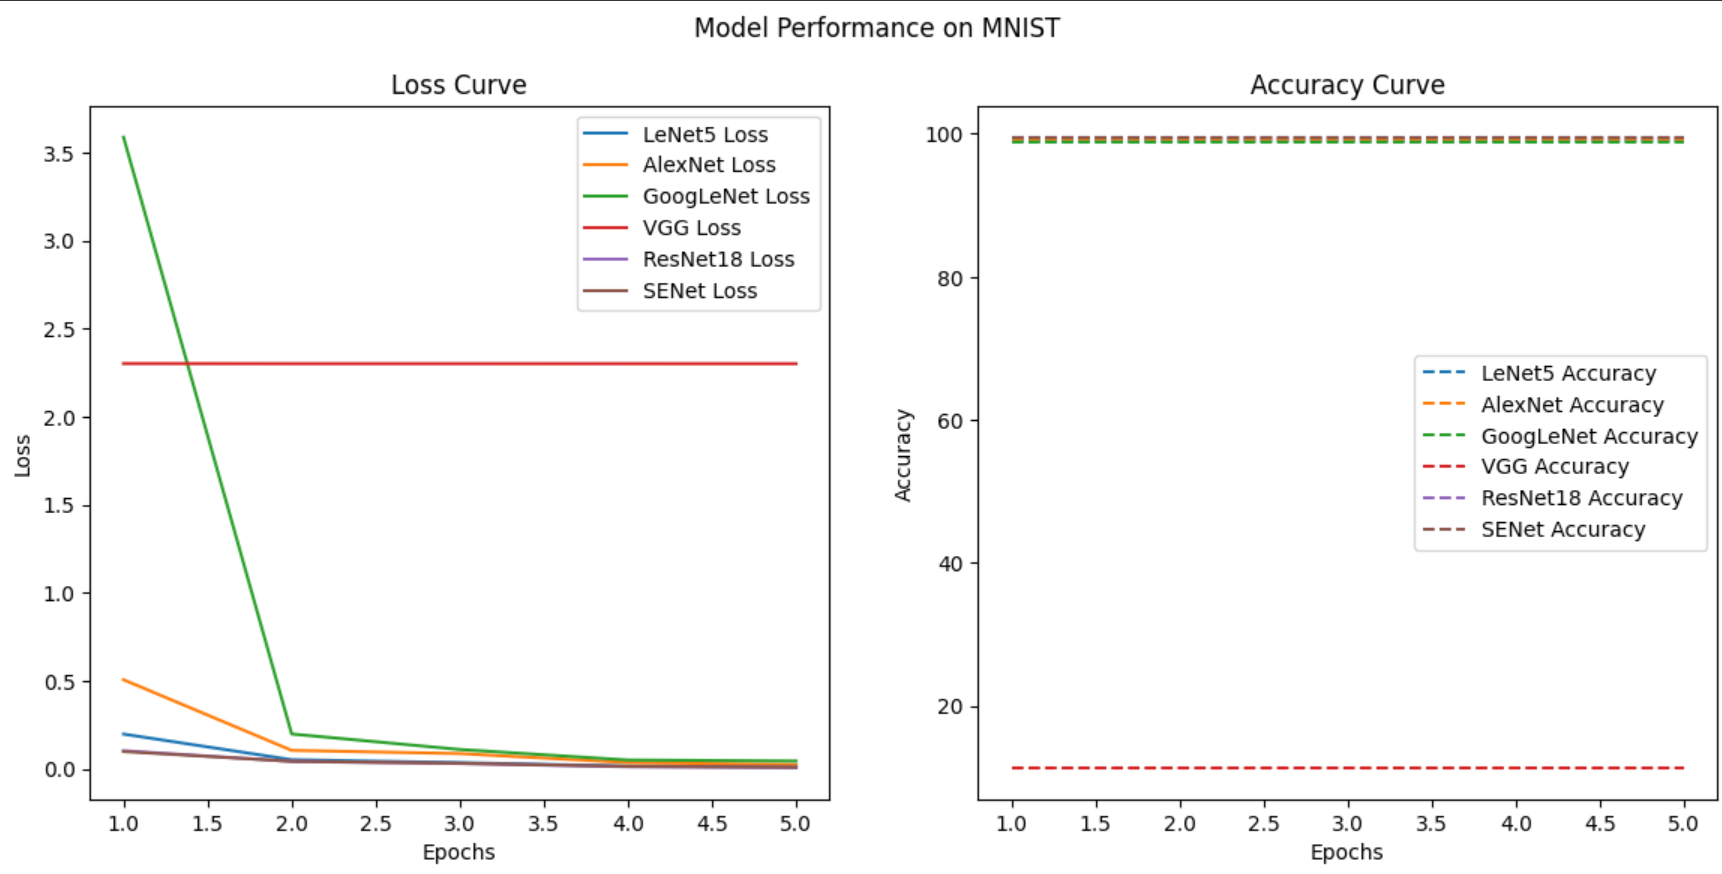

## Inefficciency Of VGG on MNIST,FMNIST & CIFAR-10 

You're right, VGG wouldn't typically achieve only 11% accuracy on MNIST and FMNIST datasets. VGG is designed for much more complex image recognition tasks with a larger number of classes (like ImageNet with thousands of categories). Here's why it wouldn't perform well on MNIST/FMNIST:

### Overkill for Simple Data: ###

MNIST and FMNIST datasets contain grayscale handwritten digits (10 classes in MNIST, 62 in FMNIST) which are much simpler than the complex, multi-class images VGG is designed for.
VGG's deep architecture with many convolutional layers is like using a sledgehammer to crack a nut. It's too complex for the relatively simple patterns in these datasets.

### Learning Difficulty: ###

The large number of parameters in VGG can make it difficult to learn effectively on small datasets like MNIST/FMNIST. The model might struggle to find the relevant features needed for accurate classification.

### Better Options for Simple Data: ###

Simpler models like LeNet or even multilayer perceptrons are much more efficient for MNIST/FMNIST. They can achieve close to 99% accuracy with fewer layers and parameters, requiring less training data.
Here's an additional point:

Even if you trained a VGG model on MNIST/FMNIST for a long time, it might eventually achieve high accuracy. However, this would be inefficient and unnecessary due to the reasons mentioned above.
In conclusion, VGG is a powerful architecture for complex image recognition tasks, but it's not the best choice for simpler datasets like MNIST and FMNIST.